# **DEMO: HAVOC on Lorenz oscillator**

In this Jupyter notebook we explore the workflow of *S. Brunton et al* applied to the Lorenz oscillator.

In [1]:
import numpy as np

#%matplotlib widget
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import colors
plt.rcParams['font.size'] = 12
#plt.rcParams['font.family'] = 'sans-serif'
#plt.rcParams['figure.titleweight'] = 'bold'
my_grey = (0.3,0.3,0.3)

import pandas as pd

import control # dynamic system simulation
import control.matlab as cnt

### Data import

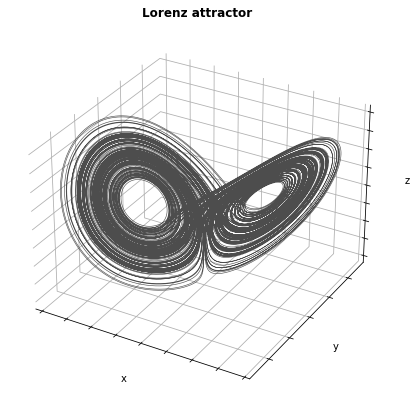

In [2]:
# load data from Lorenz oscillator
xx, yy, zz = np.loadtxt('../data/sb2017/Lorenz_extended.csv', unpack=True)
dt = 0.001

N = len(xx)
tt = dt*(np.arange(N) + 1)

# plot
fig = plt.figure(figsize=(10, 7))
ax = plt.axes(projection='3d')

ax.plot(xx, yy, zz, lw=0.6, c = my_grey )
plt.title('Lorenz attractor', fontweight='bold')

ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

ax.set_xlabel('x');  ax.set_ylabel('y'); ax.set_zlabel('z');

fig.set_facecolor('w')
plt.setp(ax.get_xticklabels(), color="w")
plt.setp(ax.get_yticklabels(), color="w")
plt.setp(ax.get_zticklabels(), color="w")

plt.show()

In [3]:
# select a coordinate for HAVOC analysis, which from now on
# will be called x, regardless of its origin
x = xx

## Part 1 | **singular value decomposition**

### build the Hankel matrix

We reshape the input timeseries $x$ to fit in a *time delay coordinate* matrix. The Hankel matrix $H$ stacks in rows a shifted copy of the original timeseries:

$$
H = 
\left[
  \begin{array}{cccc}
    x(t_1) & x(t_2) & \ldots & x(t_q) \\
    x(t_2) & x(t_3) & \ldots & x(t_{q+1}) \\
    \vdots & & & \vdots \\
    x(t_{m-q+1}) & \ldots & \ldots & x(t_m)
  \end{array}
\right]
$$

In [4]:
# number of shift-stacked rows
q = 100

In [5]:
m = len(x)
H = np.zeros((q, m-q+1))
for i in range(0, q):
    H[i,:] = x[ i:(m-q+1+i) ]
H.shape

(100, 199901)

### compute SVD

The SVD is a factorization of an input matrix: $H = U\cdot \Sigma \cdot V^T$.

$$
H = 
\left[
  \begin{array}{ccc}
     \vdots &  & \vdots\\
     \vdots& U & \vdots\\
     \vdots &  & \vdots
  \end{array}
\right]
\left[
  \begin{array}{ccc}
    \ddots & 0 & 0\\
    0 & \Sigma & 0\\
    0 & 0 & \ddots
  \end{array}
\right]
\left[
  \begin{array}{ccccc}
    \dots & \dots& \dots& \dots & \dots\\
     & & V^T & & \\
    \dots & \dots& \dots& \dots & \dots
  \end{array}
\right]
$$

"The columns of $H$, are well-approximated by the ﬁrst $r$ columns of $U$, so these eigen-time-series provide a Koopman-invariant measurement system. The ﬁrst $r$ columns of $V$ provide a time series of the magnitude of each of the columns of $U\Sigma$ in the data. By plotting the ﬁrst three columns of $V$, we obtain an embedded attractor for the Lorenz system, shown in (see below)."

In [6]:
u, s, vh = np.linalg.svd(H, full_matrices=False, compute_uv=True)

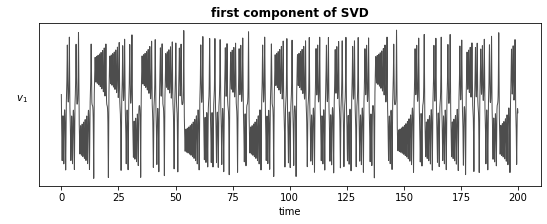

In [7]:
plt.figure( figsize=(9,3) )

plt.plot(tt[:len(vh[0])], vh[0], lw=1, c=my_grey)
plt.title('first component of SVD', fontweight='bold')
plt.xlabel('time')
plt.ylabel(r'   $v_1$         ', rotation=0)
plt.yticks([])
plt.show()

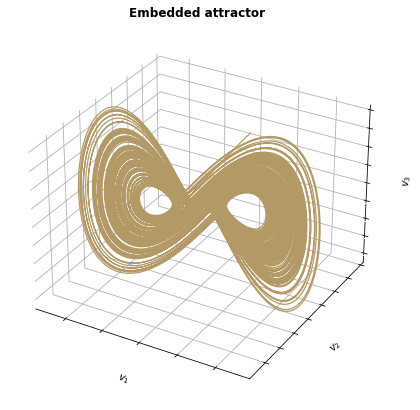

In [8]:
# plot
fig = plt.figure(figsize=(10, 7))
ax = plt.axes(projection='3d')

ax.plot(vh[0,:], vh[1,:], vh[2,:], lw=1.2, c = (0.7,0.6,0.4) )
plt.title('Embedded attractor', fontweight='bold')

ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

ax.set_xlabel(r'$v_1$');  ax.set_ylabel(r'$v_2$'); ax.set_zlabel(r'$v_3$');

fig.set_facecolor('w')
plt.setp(ax.get_xticklabels(), color="w")
plt.setp(ax.get_yticklabels(), color="w")
plt.setp(ax.get_zticklabels(), color="w")

plt.show()

## Part 2 | **regression model**

We build a regression model $$\frac{d}{dt}\mathbf{v}(t) = \mathbf{A} \mathbf{v}(t) + \mathbf{B} v_r(t) \;,$$ where $\mathbf{v} = \left[ v_1\;v_2\; \dots v_{r-1} \right]$ is a vector of the first $r-1$ eigen-time-delay coordinates (columns of $V$).

We perform the regression using **SINDy** (Sparse Identification of Nonlinear Dynamics).

### fix number of singular values

In [9]:
##   TODO (...)
## not doing this
r = 15

#  you eventually select the rows using   vh[0:r]

### compute the derivative

To compute the derivative we use the *fourth order central difference*.

In [10]:
lv = vh.shape[1]
dv_star = np.zeros( (lv-5,r) )
for i in range(2,lv-3):
    dv_star[i-2,0:r] = (1/(12*dt))*(-vh[0:r, i+2]+8*vh[0:r, i+1]-8*vh[0:r, i-1]+vh[0:r, i-2])
dv_star.shape

(199896, 15)

In [11]:
v_star = vh[0:r, 2:(dv_star.shape[0]+2)].T
v_star.shape

(199896, 15)

### create the candidate library $\Theta$

In [12]:
def SINDy_generate_library(yin,nVars=r):
    #  Dev Note: this implementation is not complete! It allows to generate only
    # degree-one polynomial Theta. Further implementations might require higher order Poly!
    n = yin.shape[0]
    yout = np.zeros( (n,1+nVars) )  # valid to poly order 1
    
    # poly order 0 (add bias term)
    yout[:,0] = np.ones((n))
    
    idx = 1
    # poly order 1
    for i in range(0, nVars):
        yout[:,idx] = yin[:,i]
        idx = idx+1
        
    # omitting higher poly order
    
    return yout

theta = SINDy_generate_library(v_star, r)
m = theta.shape[1]  # 16 values

# normalize theta
norm_theta = np.linalg.norm(theta,axis=0)  # keep this for later
theta = theta/norm_theta

### regression

To perform the **sparse regression**, we implement a custom algorythm, based on *sequential* iterations of *least squares* & hard-thresholding.

In [13]:
def sequential_threshold_least_squares(Theta, dXdt, thres, niter = 10, nleast=1):
    # SINDy optimization algorithm: sequential threshold least squares
    
    # initial guess: least squares
    Xi = np.linalg.lstsq(Theta, dXdt, rcond=None)[0]
    # ref https://numpy.org/doc/stable/reference/generated/numpy.linalg.lstsq.html
    
    for k in range(0, niter):       # repeat several times the thresholding
        mask_under_thres = (abs(Xi)<thres)
        Xi[mask_under_thres] = 0
        for j in range(0, nleast):  # repeat several times the least squares
            mask_above_thres = np.invert(mask_under_thres)
            # do again least squares
            Xi[mask_above_thres] = np.linalg.lstsq(Theta[:,mask_above_thres], 
                                                   dXdt, rcond=None )[0] 
    return Xi

In [14]:
lamb = 0   # threshold value

Xi = np.zeros( (m, r-1) )

for k in range(0, r-1):  # apply separately on each column of Xi
    Xi[:,k] = sequential_threshold_least_squares(theta, dv_star[:,k], lamb*(k+1), 1)
    
Xi.shape

(16, 14)

In [15]:
# normalize Xi on Theta's 2-norm
Xi = Xi/norm_theta[:,None]
Xi.shape

(16, 14)

In [16]:
A = Xi[1:,:].T
B = A[:,r-1]
A = A[:,:r-1]

B.shape = (r-1,1) # forcing matrix-like shape

### visualize the regression

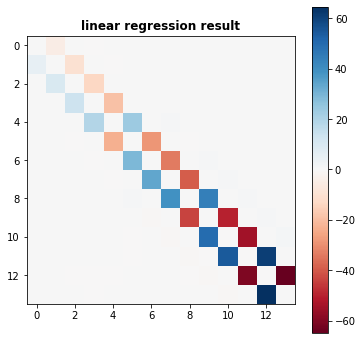

In [17]:
plt.figure(figsize=(6,6))
plt.imshow(A, cmap='RdBu', interpolation='nearest', aspect='equal', origin='upper')
plt.colorbar()
plt.title('linear regression result', fontweight='bold')
plt.show()

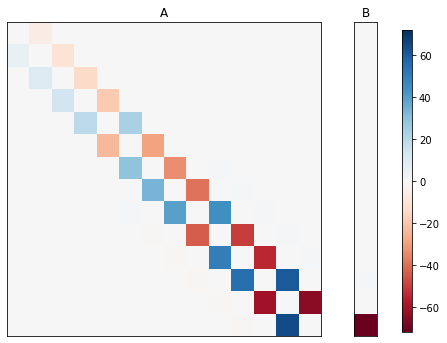

In [18]:
#plt.figure(figsize=(6,6))

fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [14, 1]}, figsize=(7,6))
fig.tight_layout()

color_limit = max( np.ceil(np.abs(A).max()), np.ceil(np.abs(B).max()) )

im = ax[0].imshow(A, cmap='RdBu', interpolation='nearest', aspect='equal', 
                  vmin=-color_limit, vmax=color_limit)
ax[0].set(title='A')  # eventually   ylabel='$A$'
plt.setp(ax[0].get_xticklabels(), visible=False)
plt.setp(ax[0].get_yticklabels(), visible=False)
ax[0].tick_params(axis='both', which='both', length=0)
 
ax[1].imshow(B, cmap='RdBu', interpolation='nearest', aspect='equal', 
             vmin=-color_limit, vmax=color_limit)
ax[1].set(title='B')
plt.setp(ax[1].get_xticklabels(), visible=False)
plt.setp(ax[1].get_yticklabels(), visible=False)
ax[1].tick_params(axis='both', which='both', length=0)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.16, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()

In [19]:
# print A values as plain text
#with np.printoptions(precision=2, suppress=True, formatter={'float': '{:0.2f}'.format}, linewidth=100):
#    print(A)

pd.DataFrame(A).round(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,-0.00,-5.13,-0.00,-0.12,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00
1,5.12,-0.01,-9.92,-0.00,-0.19,0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00
2,-0.00,9.89,-0.02,-13.58,-0.00,0.24,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00
3,0.11,-0.05,13.52,-0.05,-18.90,0.00,0.33,0.00,0.01,-0.00,-0.00,-0.00,0.00,0.00
4,-0.01,0.15,-0.05,18.81,-0.03,23.24,0.00,0.41,0.00,-0.01,-0.00,-0.00,0.00,0.00
5,0.00,0.04,-0.19,0.09,-23.17,-0.04,-28.90,-0.00,-0.51,0.00,0.01,0.00,-0.00,-0.00
6,0.00,0.01,0.02,-0.30,0.02,28.87,-0.00,-33.48,-0.00,0.59,0.00,0.01,-0.00,-0.00
7,0.00,0.00,0.00,0.01,-0.40,-0.01,33.48,0.00,-39.29,0.00,0.69,0.00,-0.01,-0.00
8,-0.01,-0.03,-0.04,-0.07,-0.06,0.56,0.02,39.29,-0.02,43.91,0.00,0.78,-0.00,-0.01
9,0.01,0.05,0.06,0.10,0.09,-0.09,-0.62,-0.01,-43.84,-0.05,-49.94,-0.00,0.89,0.00


## Part 3 | **dynamics reconstruction**

In [20]:
sys = control.StateSpace(A, B, np.eye(r-1), 0*B)

In [21]:
L = 50000

forcing = v_star[0:L,r-1]
forcing_t = dt*(np.arange(L) + 1)
x0 = v_star[0,0:r-1]
yout, T, xout = cnt.lsim(sys, forcing, forcing_t, x0)

In [22]:
# first 3 eigen-time-delay coordinate
vr1 = yout[:,0]
vr2 = yout[:,1]
vr3 = yout[:,2]
vrtt = tt[:len(vr1)]

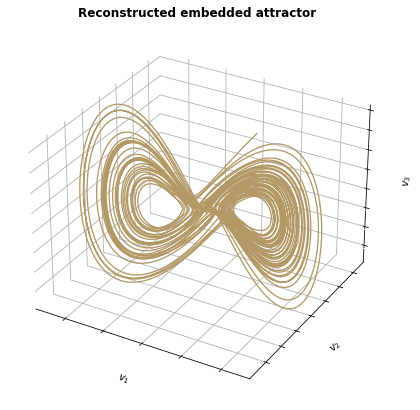

In [23]:
# plot
fig = plt.figure(figsize=(10, 7))
ax = plt.axes(projection='3d')

ax.plot(vr1, vr2, vr3, lw=1.3, c = (0.7,0.6,0.4) )
plt.title('Reconstructed embedded attractor', fontweight='bold')

ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

ax.set_xlabel(r'$v_1$');  ax.set_ylabel(r'$v_2$'); ax.set_zlabel(r'$v_3$');

fig.set_facecolor('w')
plt.setp(ax.get_xticklabels(), color="w")
plt.setp(ax.get_yticklabels(), color="w")
plt.setp(ax.get_zticklabels(), color="w")

plt.show()

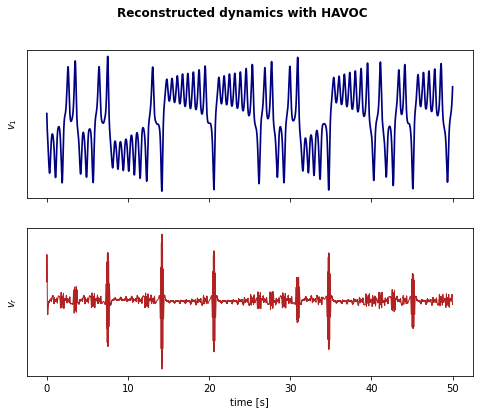

In [24]:
fig, ax = plt.subplots(2, 1, figsize=(8,6))

ax[0].plot(vrtt, vr1, lw=1.7, c='navy')
ax[0].set(ylabel='$v_1$')
ax[0].set_yticks([])
plt.setp(ax[0].get_xticklabels(), visible=False)
plt.setp(ax[0].get_yticklabels(), visible=False)

ax[1].plot(tt[:len(yout[:,0])], forcing, lw=1, c='firebrick')
ax[1].set(ylabel='$v_r$')
ax[1].set_yticks([])

plt.xlabel('time [s]')
fig.suptitle('Reconstructed dynamics with HAVOC', fontweight='bold')
plt.show()

## Part 4 | **lobe switching prediction**

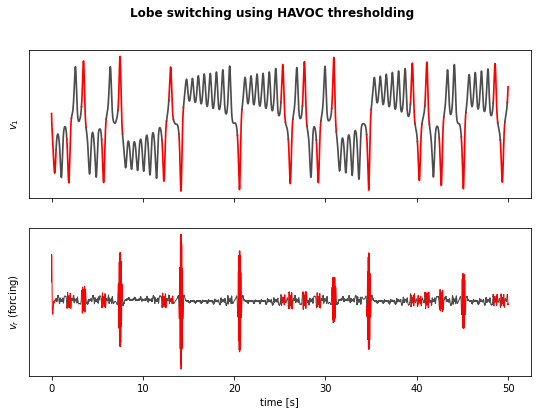

In [25]:
# thresholding + interval smoothing
thres = 4.0e-6
above_thres = forcing**2 > thres

thres_expand = 500
switch = False
for i in range(0,len(above_thres)):
    if above_thres[i]:
        if not switch:
            above_thres[i:i+thres_expand] = True
            switch = True
    else:
        switch = False


# plotting
fig, ax = plt.subplots(2, 1, figsize=(9,6))

yabove = np.ma.masked_where(np.invert(above_thres), vr1)
ybelow = np.ma.masked_where(above_thres, vr1)
ax[0].plot(vrtt, yabove,  lw=1.7, c = 'red')
ax[0].plot(vrtt, ybelow,  lw=1.7, c = my_grey)
ax[0].set(ylabel='$v_1$')
ax[0].set_yticks([])
plt.setp(ax[0].get_xticklabels(), visible=False)
plt.setp(ax[0].get_yticklabels(), visible=False)

yabove = np.ma.masked_where(np.invert(above_thres), forcing)
ybelow = np.ma.masked_where(above_thres, forcing)
ax[1].plot(vrtt, yabove,  lw=1, c = 'red')
ax[1].plot(vrtt, ybelow,  lw=1, c = my_grey)
ax[1].set(ylabel='$v_r$ (forcing)')
ax[1].set_yticks([])

plt.xlabel('time [s]')
fig.suptitle('Lobe switching using HAVOC thresholding', fontweight='bold')
plt.show()

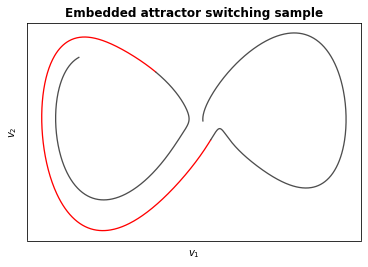

In [26]:
# plot
#plt.figure(figsize=(10, 7))
rgg = np.arange(1000,3000)  # select range

yabove1 = np.ma.masked_where(np.invert(above_thres)[rgg], vr1[rgg])
yabove2 = np.ma.masked_where(np.invert(above_thres)[rgg], vr2[rgg])
plt.plot(yabove1, yabove2,  lw=1.3, c = 'red')

ybelow1 = np.ma.masked_where(above_thres[rgg], vr1[rgg])
ybelow2 = np.ma.masked_where(above_thres[rgg], vr2[rgg])
plt.plot(ybelow1, ybelow2, lw=1.3, c = my_grey )

plt.xlabel(r'$v_1$');    plt.ylabel(r'$v_2$');
plt.xticks([]);          plt.yticks([]);
plt.title('Embedded attractor switching sample', fontweight='bold')

plt.show()

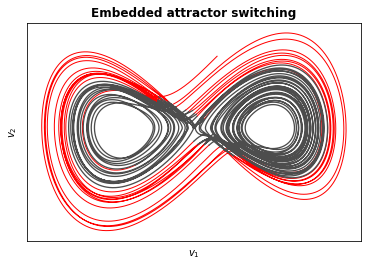

In [27]:
# plot
#plt.figure(figsize=(10, 7))
rgg = np.arange(0,len(vr1))  # select range

yabove1 = np.ma.masked_where(np.invert(above_thres)[rgg], vr1[rgg])
yabove2 = np.ma.masked_where(np.invert(above_thres)[rgg], vr2[rgg])
yabove3 = np.ma.masked_where(np.invert(above_thres)[rgg], vr3[rgg])
plt.plot(yabove1, yabove2,  lw=1, c = 'red')

ybelow1 = np.ma.masked_where(above_thres[rgg], vr1[rgg])
ybelow2 = np.ma.masked_where(above_thres[rgg], vr2[rgg])
ybelow3 = np.ma.masked_where(above_thres[rgg], vr3[rgg])
plt.plot(ybelow1, ybelow2, lw=1.3, c = my_grey )

plt.xlabel(r'$v_1$');    plt.ylabel(r'$v_2$');
plt.xticks([]);          plt.yticks([]);
plt.title('Embedded attractor switching', fontweight='bold')

plt.show()

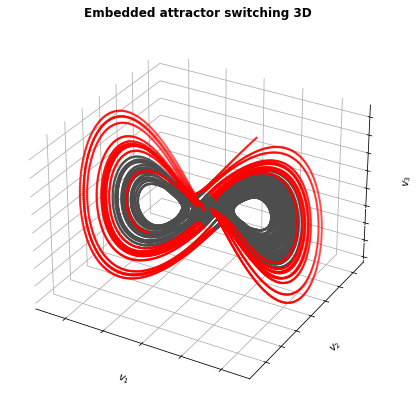

In [28]:
# plot
fig = plt.figure(figsize=(10, 7))
ax = plt.axes(projection='3d')

ax.scatter(yabove1, yabove2, yabove3, s=2, color = 'red')
ax.scatter(ybelow1, ybelow2, ybelow3, s=2, color = my_grey)
plt.title('Embedded attractor switching 3D', fontweight='bold')

ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

ax.set_xlabel(r'$v_1$');  ax.set_ylabel(r'$v_2$'); ax.set_zlabel(r'$v_3$');

fig.set_facecolor('w')
plt.setp(ax.get_xticklabels(), color="w")
plt.setp(ax.get_yticklabels(), color="w")
plt.setp(ax.get_zticklabels(), color="w")

plt.show()

## Part 5 | **sliding window**